In [1]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Paths to your original dataset folders
cancer_path = '/content/drive/MyDrive/Oral Cancer/Oral Cancer Dataset/CANCER'
non_cancer_path = '/content/drive/MyDrive/Oral Cancer/Oral Cancer Dataset/NON CANCER'

# Define the new dataset structure
base_path = '/content/drive/MyDrive/Oral Cancer/Oral Cancer Dataset'
train_path = os.path.join(base_path, 'train')
test_path = os.path.join(base_path, 'test')

# Create the new directory structure
for path in [train_path, test_path]:
    os.makedirs(os.path.join(path, 'cancer'), exist_ok=True)
    os.makedirs(os.path.join(path, 'non_cancer'), exist_ok=True)

# Get list of files
cancer_files = os.listdir(cancer_path)
non_cancer_files = os.listdir(non_cancer_path)

# Split the data into train and test sets (80% train, 20% test)
train_cancer, test_cancer = train_test_split(cancer_files, test_size=0.2, random_state=42)
train_non_cancer, test_non_cancer = train_test_split(non_cancer_files, test_size=0.2, random_state=42)

# Function to copy files to the new directories
def copy_files(file_list, src_folder, dest_folder):
    for file_name in file_list:
        src_file = os.path.join(src_folder, file_name)
        dest_file = os.path.join(dest_folder, file_name)
        shutil.copy(src_file, dest_file)

# Copy cancer files
copy_files(train_cancer, cancer_path, os.path.join(train_path, 'cancer'))
copy_files(test_cancer, cancer_path, os.path.join(test_path, 'cancer'))

# Copy non_cancer files
copy_files(train_non_cancer, non_cancer_path, os.path.join(train_path, 'non_cancer'))
copy_files(test_non_cancer, non_cancer_path, os.path.join(test_path, 'non_cancer'))

print("Files copied successfully.")



Files copied successfully.


In [5]:
from keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = [224, 224]

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size=IMAGE_SIZE,
                                                 batch_size=32,
                                                 class_mode='categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=IMAGE_SIZE,
                                            batch_size=32,
                                            class_mode='categorical')


Found 600 images belonging to 2 classes.
Found 150 images belonging to 2 classes.


In [6]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16

# Load the VGG16 model
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# Freeze the existing layers
for layer in vgg.layers:
    layer.trainable = False

# Add custom layers
x = Flatten()(vgg.output)
prediction = Dense(len(training_set.class_indices), activation='softmax')(x)

# Create the model object
model = Model(inputs=vgg.input, outputs=prediction)

# View the structure of the model
model.summary()


58889256/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [7]:
from keras.optimizers import Adam

# Compile the model
model.compile(
  loss='categorical_crossentropy',
  optimizer=Adam(lr=0.001),
  metrics=['accuracy']
)

# Train the model
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)


Epoch 1/10
14/19 [=====================>........] - ETA: 1:33 - loss: 0.8428 - accuracy: 0.6705

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


19/19 [==============================] - 455s 24s/step - loss: 0.7160 - accuracy: 0.7133 - val_loss: 0.4519 - val_accuracy: 0.8200
Epoch 2/10
19/19 [==============================] - 441s 23s/step - loss: 0.2972 - accuracy: 0.8917 - val_loss: 0.2464 - val_accuracy: 0.9267
Epoch 3/10
19/19 [==============================] - 444s 23s/step - loss: 0.2027 - accuracy: 0.9350 - val_loss: 0.2494 - val_accuracy: 0.9200
Epoch 4/10
19/19 [==============================] - 445s 24s/step - loss: 0.1729 - accuracy: 0.9517 - val_loss: 0.2176 - val_accuracy: 0.9400
Epoch 5/10
19/19 [==============================] - 495s 26s/step - loss: 0.1368 - accuracy: 0.9517 - val_loss: 0.2333 - val_accuracy: 0.9000
Epoch 6/10
19/19 [==============================] - 441s 24s/step - loss: 0.1275 - accuracy: 0.9567 - val_loss: 0.2381 - val_accuracy: 0.9200
Epoch 7/10
19/19 [==============================] - 440s 23s/step - loss: 0.1079 - accuracy: 0.9783 - val_loss: 0.2920 - val_accuracy: 0.8933
Epoch 8/10
19/19 

In [8]:
# Evaluate the model
loss, accuracy = model.evaluate(test_set)
print(f'Test Accuracy: {accuracy*100:.2f}%')


5/5 [==============================] - 88s 17s/step - loss: 0.2148 - accuracy: 0.9400
Test Accuracy: 94.00%


In [12]:
model.save('/content/drive/MyDrive/oral_cancer_model.h5')
print("Model saved successfully.")


Model saved successfully.


Saving noncancertest.jpeg to noncancertest.jpeg


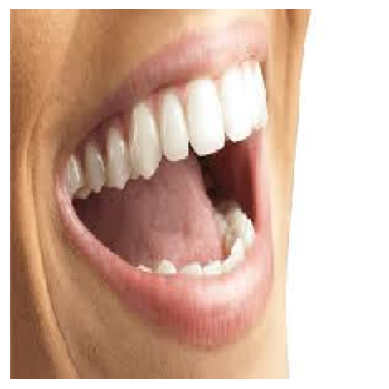

1/1 [==============================] - 1s 807ms/step
Predicted class: non_cancer


In [14]:
# Step 1: Upload the Image
from google.colab import files
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

uploaded = files.upload()

for fn in uploaded.keys():
    path = fn
    img = image.load_img(path, target_size=(224, 224))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Step 2: Preprocess the Image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Rescale by 1/255
    return img_array

img_array = preprocess_image(path)

# Step 3: Load the Model
from keras.models import load_model

model_save_path = '/content/drive/MyDrive/oral_cancer_model.h5'
model = load_model(model_save_path)

# Step 4: Make Predictions
predictions = model.predict(img_array)

predicted_class = np.argmax(predictions, axis=1)

class_indices = {v: k for k, v in training_set.class_indices.items()}
predicted_class_name = class_indices[predicted_class[0]]

print(f'Predicted class: {predicted_class_name}')
